# **Proyecto 2 : Análisis de señales ECG**

## Andres Banquez- Melina Villada

1. De los artículos:

https://www.nature.com/articles/s41746-023-00966-w

https://www.nature.com/articles/s41598-020-59821-7

https://www.sciencedirect.com/science/article/pii/S2405844024032316

Para cada artículo hacer un diagrama de flujo de las metodologías usadas en los artículos (10%)

Explicar en sus palabras las metodologías desarrolladas (10%)



*Prediction of atrial fibrillation from at-home single-lead ECG signals without arrhythmias*

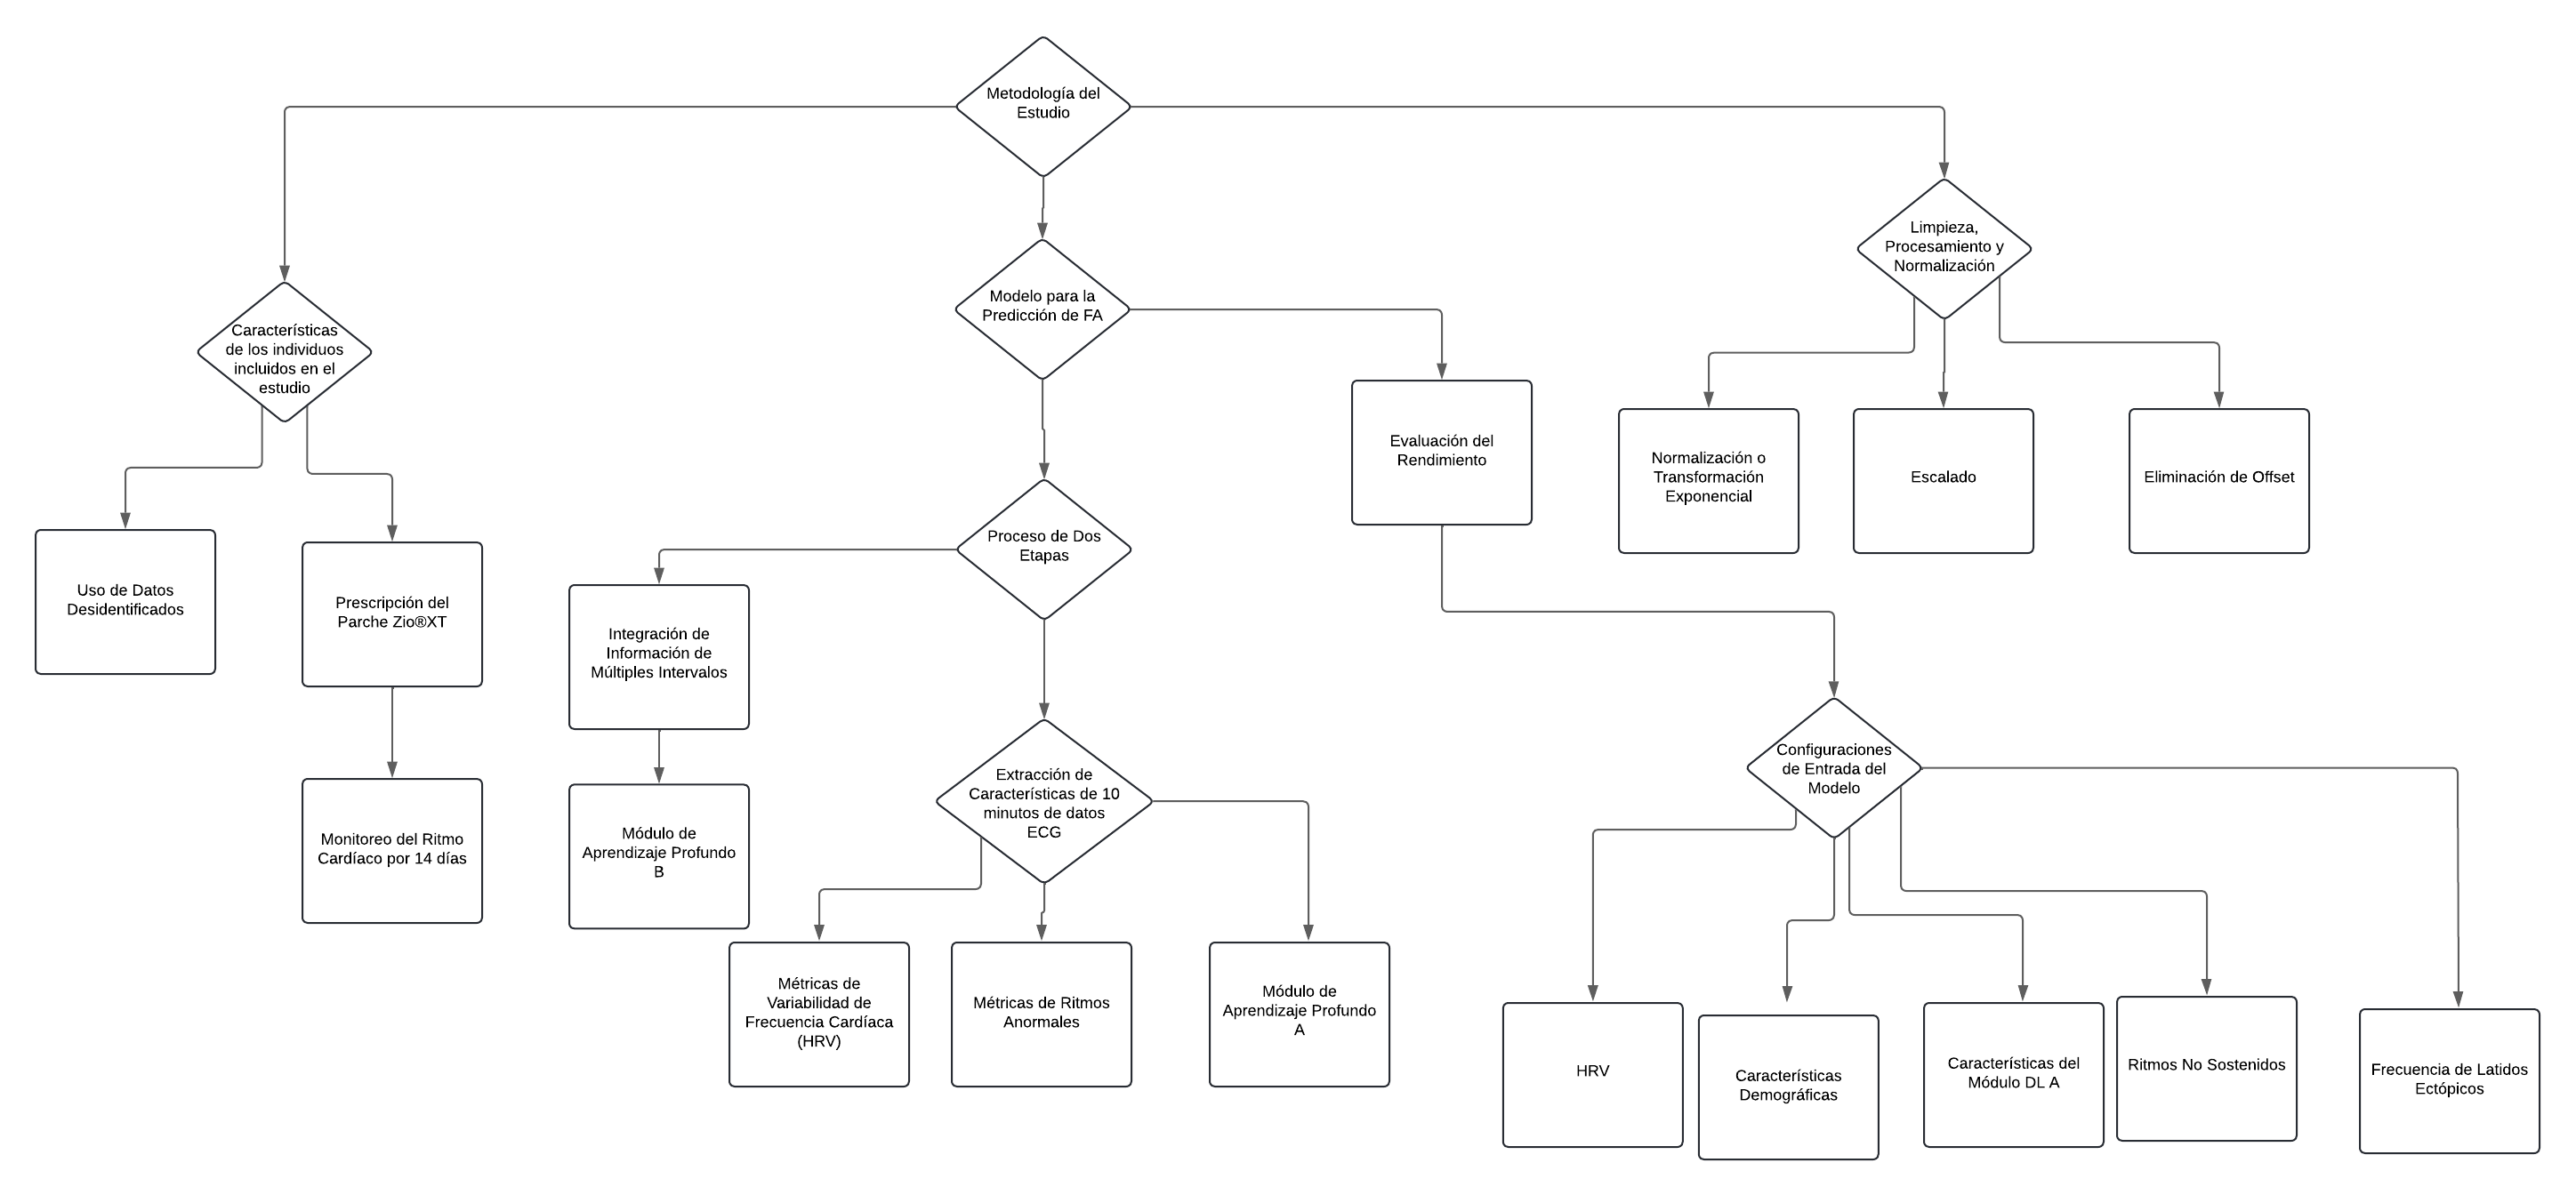

*Optimal Multi-Stage Arrhythmia Classification Approach*

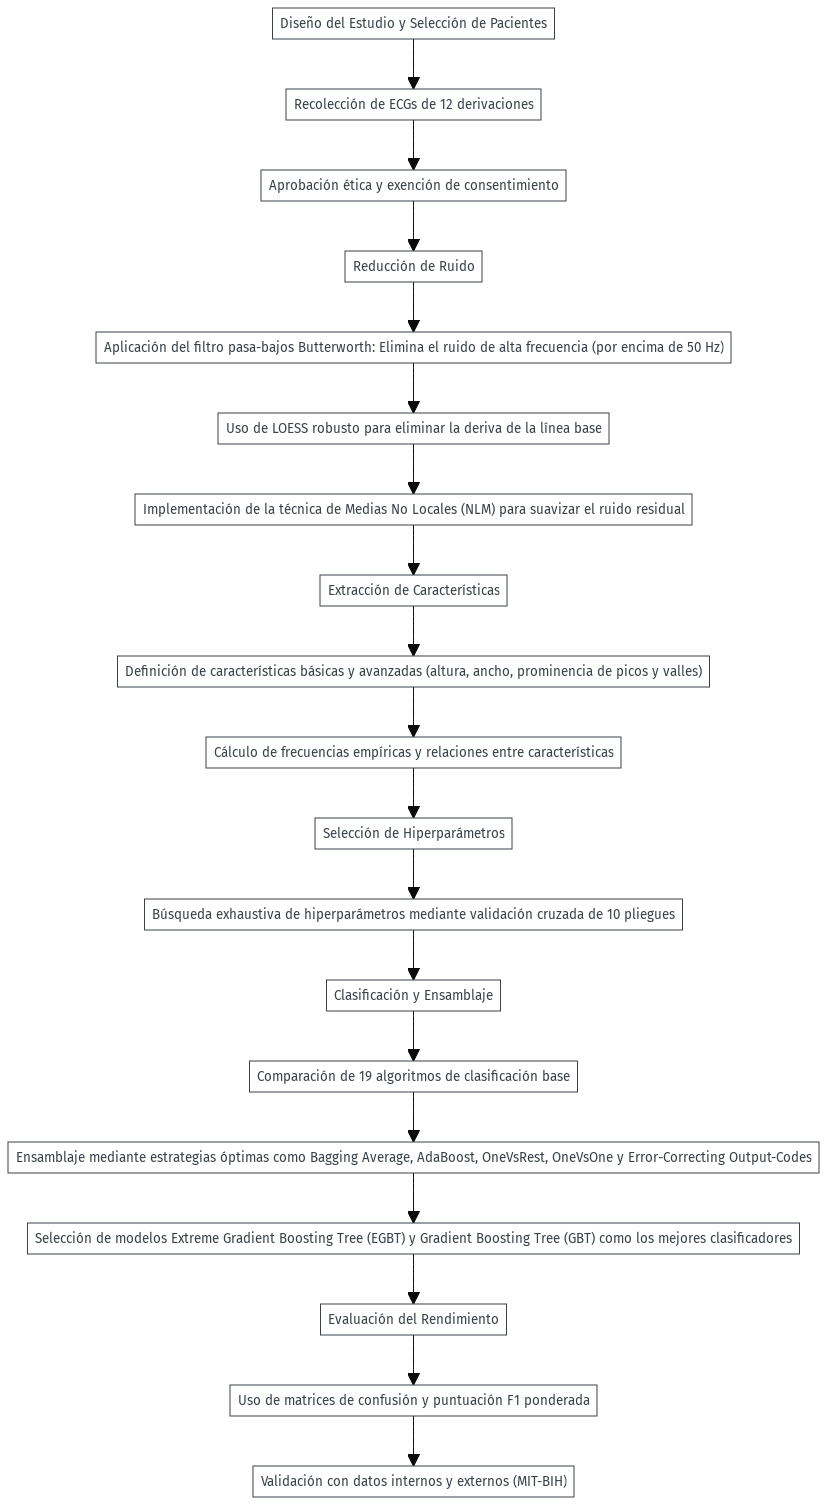

*An Arrhythmia classification approach via deep learning using single-lead ECG without QRS wave detection*

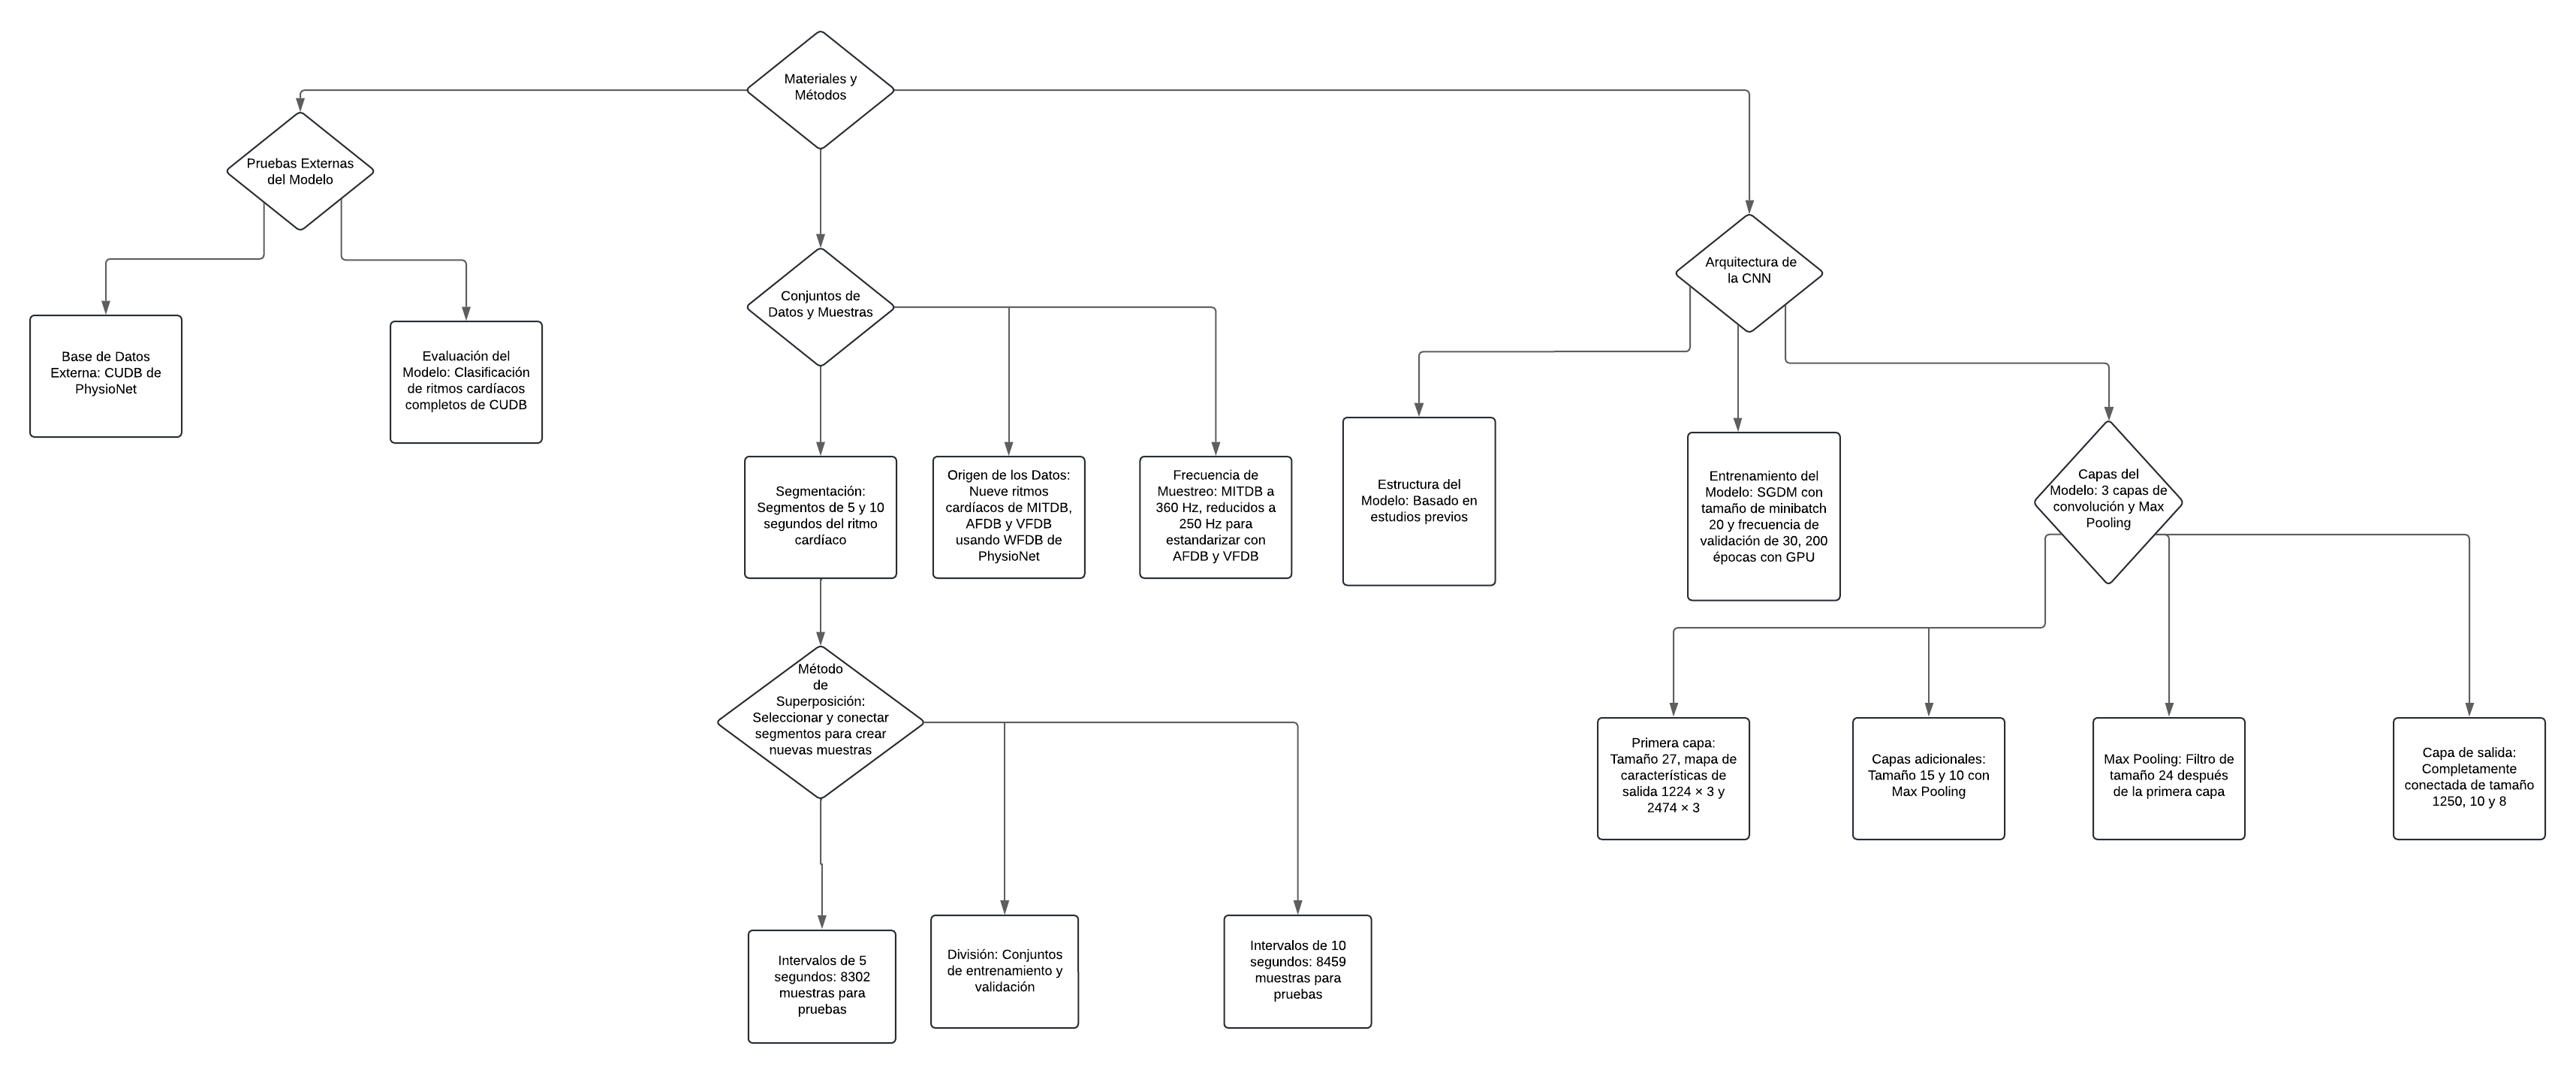

2. Descargar los datos ECGDataDenoised.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [2]:
import pandas as pd
from scipy.signal import detrend

In [5]:
diagnostics_path = 'Diagnostics.xlsx'
diagnostics_df = pd.read_excel(diagnostics_path)
sbyafib_df=diagnostics_df[diagnostics_df['Rhythm'].isin(['AFIB', 'SB'])]
needed_files = sbyafib_df['FileName'].tolist()
needed_files

['MUSE_20180113_171327_27000',
 'MUSE_20180112_073319_29000',
 'MUSE_20180113_121940_44000',
 'MUSE_20180112_120347_79000',
 'MUSE_20180114_075026_69000',
 'MUSE_20180114_075128_92000',
 'MUSE_20180118_174026_42000',
 'MUSE_20180115_125443_25000',
 'MUSE_20180113_134825_04000',
 'MUSE_20180114_070718_20000',
 'MUSE_20180115_133559_70000',
 'MUSE_20180113_133901_16000',
 'MUSE_20180113_071734_35000',
 'MUSE_20180114_121218_64000',
 'MUSE_20180113_075301_94000',
 'MUSE_20180114_122918_82000',
 'MUSE_20180118_135246_80000',
 'MUSE_20180116_123940_90000',
 'MUSE_20180118_132124_94000',
 'MUSE_20180118_134426_93000',
 'MUSE_20180116_130527_79000',
 'MUSE_20180114_075003_61000',
 'MUSE_20180113_131417_18000',
 'MUSE_20180116_124959_22000',
 'MUSE_20180114_073026_18000',
 'MUSE_20180113_074740_85000',
 'MUSE_20180116_132201_77000',
 'MUSE_20180114_132044_36000',
 'MUSE_20180115_124515_42000',
 'MUSE_20180116_131337_59000',
 'MUSE_20180113_183351_27000',
 'MUSE_20180114_072951_09000',
 'MUSE_2

3. De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

Programar las fórmulas 1 al 4 que se encuentran en el artículo (15%). Consultar que significado y utilidad del biespectro (Realice la gráfica) (5%)
https://arxiv.org/pdf/1809.08451


###Biespectro
El bispectrum es una herramienta de análisis de señales que forma parte del análisis espectral de orden superior (Higher Order Spectral Analysis, HOSA). A diferencia del espectro de potencia tradicional, que analiza la distribución de la energía de una señal en función de la frecuencia, el bispectrum proporciona información adicional sobre las relaciones de fase entre las componentes frecuenciales de la señal.
El bispectrum es la transformación de Fourier de la función de autocorrelación de tercer orden de una señal. Matemáticamente, para una señal 
𝑥(𝑡), el bispectrum 𝐵 (𝑓1,𝑓2) se define como:

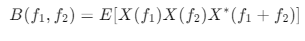 [1]

Se utiliza principalmente para:

* Detección de No Linealidades: El bispectrum es particularmente útil para detectar y caracterizar no linealidades en señales. Esto es posible porque las no linealidades generan acoplamiento de fase entre diferentes componentes frecuenciales, lo cual es capturado por el bispectrum.

* Identificación de Interacciones de Fase: A diferencia del espectro de potencia, que solo proporciona información sobre la magnitud de las componentes frecuenciales, el bispectrum también informa sobre las relaciones de fase entre estas componentes. Esto es crucial para entender las interacciones y acoplamientos en sistemas complejos.

* Reducción de Ruido: El bispectrum puede diferenciar entre señales de origen dinámico y componentes de ruido. Las componentes de ruido no muestran coherencia de fase, mientras que las componentes de señal sí lo hacen. Por lo tanto, el bispectrum puede ser utilizado para filtrar el ruido y extraer la señal de interés.

* Aplicaciones en Biomedicina: En el análisis de señales biomédicas, como ECG y EEG, el bispectrum se utiliza para detectar y caracterizar patrones asociados con diversas condiciones médicas, como arritmias cardíacas y epilepsia.

* 3.1.1 Detrending

In [ ]:
xyz = xyz.apply(detrend, axis=0)
print(xyz)

* 3.1.2 Compression
* 3.2 Power Spectral analysis
* 3.3 Higher Order Spectral Analysis
* 3.4 2.4.Main peak bicoherence filter

4. Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela (15%)

5. Para cada señal sumar el número de frecuencias que son significativas para bicoherencia (cuales tienen un valor superior a ![image.png](attachment:image.png) (20%)

6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP) y suma de frecuencias significativas en bicoherencia (sFSB):

![image-2.png](attachment:image-2.png)

7. Para las señales de análisis del punto 2 aplicar las rutinas del punto 3 al 5 y hacer un informe que permita evidenciar las diferencias entre las señales SB y AFIB utilizando las herramientas de estadística descriptiva (5%)

8. Indicar si hay o no diferencias estadísticas entre las características espectrales del punto 4 y 5 para las dos poblaciones de estudio (5%)












9.Hacer un informe con todos los puntos anteriores (15%)

Trabajo sin sustentar no se califica

# **Bibliografía**

[1] Mariño, W. A. (2016). BIESPECTRO. www.academia.edu. https://www.academia.edu/28141592/BIESPECTRO 